In [1]:
# !pip install dataframe-image

In [2]:
# !pip install tabulate

Carrega os catalogos do gammapy

Verifica a existencia da fonte em cada um dos catalgos

Guarda a tabela dos pontos de fluxos

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from gammapy.datasets import FluxPointsDataset, Datasets
from gammapy.catalog import CATALOG_REGISTRY

In [5]:
import os
import sys
import importlib

module_path = os.path.abspath('modules/spectral_models')
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
import spectral_models
importlib.reload(spectral_models)
from spectral_models import pwl_model

/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/simulations/LHAASO/modules/spectral_models


In [6]:
from astropy import units as u

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
)

In [7]:
from pathlib import Path
def mkdir_base_child(base_dir, child_dir):
    '''Creates a directory: base_dir/child_dir and returs the path 
    mkdir_base_child(base_dir, child_dir)
    >>> path_child
    '''
    path_base = Path(f"{base_dir}")
    path_base.mkdir(exist_ok=True)

    path_child = Path(f"{path_base}/{child_dir}")
    path_child.mkdir(exist_ok=True)
    
    return path_child

In [29]:
def print_SED(spec_model = None, sed_type = "e2dnde", yaxis_units="TeV cm-2 s-1", energy_bounds= [1e-5, 1e2] * u.TeV, ylim = [1e-13, 1e-9]):
    '''Returns a spectral energy distribution
    
    print_SED(spec_model, yaxis_units, sed_type, reference)
    >>> model 
    
    Default function parameters
    ----------
    sed_type = "e2dnde"
    yaxis_units="TeV cm-2 s-1"
    ----------
    '''
    path_name=mkdir_base_child("catalogs_data", "flux_points")
    ax = plt.subplot()
    ax.yaxis.set_units(u.Unit(yaxis_units))
    ax.xaxis.set_units(u.Unit("TeV"))

    #label = f"{sky_model}"
    
    kwargs = {
        "ax": ax, 
        "sed_type": sed_type
    }    
    for d in datasets:
        d.data.plot(label=d.name, **kwargs)

    try:   
        kwargs_fit = {"label":sky_model.name}
        spec_model.plot(energy_bounds=energy_bounds, color="k", **kwargs, **kwargs_fit)
        spec_model.plot_error(energy_bounds=energy_bounds, **kwargs)
        file = path_name / f'{LHAASO_id}_{TeVCount_id}_{sky_model.name}.png'
    except:
        file = path_name / f'{LHAASO_id}_{TeVCount_id}.png'
    
    ax.set_ylim(ylim)
    ax.set_xlim(energy_bounds)
    ax.legend()
    
    plt.title(f"{LHAASO_src}: {TeVCount_src}")
        
    plt.savefig(file, bbox_inches='tight')
    plt.show()
    
    return 

In [9]:
catalog_gammacat = CATALOG_REGISTRY.get_cls("gamma-cat")()
catalog_hgps = CATALOG_REGISTRY.get_cls("hgps")()
catalog_2hwc = CATALOG_REGISTRY.get_cls("2hwc")()
catalog_3fgl = CATALOG_REGISTRY.get_cls("3fgl")()
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_2fhl = CATALOG_REGISTRY.get_cls("2fhl")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()
catalog_3hwc = CATALOG_REGISTRY.get_cls("3hwc")()

In [10]:
print(CATALOG_REGISTRY)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 



In [11]:
catalog_tag = ["gamma-cat", "hgps", "2hwc", "3hwc", "3fgl", "4fgl", "2fhl", "3fhl"] 

In [12]:
# catalogs = []
# for i in range(len(catalog_tag)):
#     catalog = CATALOG_REGISTRY.get_cls(catalog_tag[i])()
#     catalogs.append(catalog)
#     print(f"{catalog}  tag: {catalog.tag}")

In [13]:
TeVCount_dict = {
    "LHAASO J1825-1326": ["HESS J1825-137", "HESS J1826-130", "2HWC J1825-134"], 
    "LHAASO J1908+0621": ["MGRO J1908+06" , "HESS J1908+063", "ARGO J1907+0627", "VER J1907+062", "2HWC J1908+063"], 
    "LHAASO J2226+6057": ["VER J2227+608"  , "Boomerang"]
}

In [14]:
import pandas as pd 
from pandas import read_csv

path_name=mkdir_base_child("catalogs_data", "flux_points")

format_file = ".csv"
sed_type="dnde"
lst=[]
ds_lst = []

for i in range(len(TeVCount_dict.keys())):
    LHAASO_src = list(TeVCount_dict.keys())[i]
    LHAASO_id = LHAASO_src.replace(" ", "")

    for j in range(len(TeVCount_dict[LHAASO_src])):
        cat_off = []
        cat_on = []

        pf_off = []
        pf_on = []
        src_on = []
        
        ds_j=[]

        TeVCount_src=TeVCount_dict[LHAASO_src][j]
        TeVCount_id = TeVCount_src.replace(" ", "")
        for k in range(len(catalog_tag)): 
            cat_name = catalog_tag[k]

            try:
                cat=CATALOG_REGISTRY.get_cls(cat_name)()
                src=cat[TeVCount_src]
                cat_on.append(catalog_tag[k])

                ds = FluxPointsDataset(
                    data=src.flux_points, 
                    name=cat_name
                )
                
                ds_j.append(ds)
                pf_on.append(catalog_tag[k])

                table = ds.data.to_table(
                    sed_type=sed_type, 
                    formatted=True
                )
                file_name = f'{LHAASO_id}_{TeVCount_id}_{cat_name}{format_file}'
                path_os = os.path.abspath(
                    os.path.join(
                        f"{path_name}/{file_name}"
                    )
                )
                src_on.append(src.data)
                
                if path_os not in sys.path:
                    sys.path.append(path_os)

                table.write(f"{path_os}",format='ascii.ecsv', overwrite=True)
                

            except:
                cat_off.append(catalog_tag[k])

            lst_k=[LHAASO_src, TeVCount_src, cat_on, pf_on, ds_j, src_on]
        lst.append(lst_k)
        ds_lst.append(ds_j)

df = pd.DataFrame(lst, columns =['LHAASO', 'TeV Conterpart', 'Catalog', 'Flux Points', 'ds', 'src']) 
df.to_csv(f"{path_name}/flux_points.csv", index = True )

In [15]:
df

,LHAASO,TeV Conterpart,Catalog,Flux Points,ds,src
0,LHAASO J1825-1326,HESS J1825-137,"[gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl]","[gamma-cat, hgps, 3fgl, 4fgl, 2fhl, 3fhl]",[FluxPointsDataset\n-----------------\n\n Nam...,"[{'source_id': 118, 'common_name': 'HESS J1825..."
1,LHAASO J1825-1326,HESS J1826-130,"[gamma-cat, hgps, 4fgl, 3fhl]","[gamma-cat, hgps, 4fgl, 3fhl]",[FluxPointsDataset\n-----------------\n\n Nam...,"[{'source_id': 161, 'common_name': 'HESS J1826..."
2,LHAASO J1825-1326,2HWC J1825-134,[2hwc],[],[],[]
3,LHAASO J1908+0621,MGRO J1908+06,"[gamma-cat, 3fgl, 4fgl]","[gamma-cat, 3fgl, 4fgl]",[FluxPointsDataset\n-----------------\n\n Nam...,"[{'source_id': 132, 'common_name': 'MGRO J1908..."
4,LHAASO J1908+0621,HESS J1908+063,"[gamma-cat, hgps]","[gamma-cat, hgps]",[FluxPointsDataset\n-----------------\n\n Nam...,"[{'source_id': 132, 'common_name': 'MGRO J1908..."
5,LHAASO J1908+0621,ARGO J1907+0627,[gamma-cat],[gamma-cat],[FluxPointsDataset\n-----------------\n\n Nam...,"[{'source_id': 132, 'common_name': 'MGRO J1908..."
6,LHAASO J1908+0621,VER J1907+062,[gamma-cat],[gamma-cat],[FluxPointsDataset\n-----------------\n\n Nam...,"[{'source_id': 132, 'common_name': 'MGRO J1908..."
7,LHAASO J1908+0621,2HWC J1908+063,[2hwc],[],[],[]
8,LHAASO J2226+6057,VER J2227+608,[],[],[],[]
9,LHAASO J2226+6057,Boomerang,"[3fgl, 4fgl]","[3fgl, 4fgl]",[FluxPointsDataset\n-----------------\n\n Nam...,"[{'Source_Name': '3FGL J2229.0+6114 ', 'RAJ200..."


In [19]:
src_index = 0

LHAASO_src = list(dict(df["LHAASO"]).values())[src_index]
LHAASO_id = LHAASO_src.replace(" ", "")

TeVCount_src = list(dict(df["TeV Conterpart"]).values())[src_index]
TeVCount_id = TeVCount_src.replace(" ", "")

ds_src = ds_lst[src_index]
datasets = Datasets(ds_src)


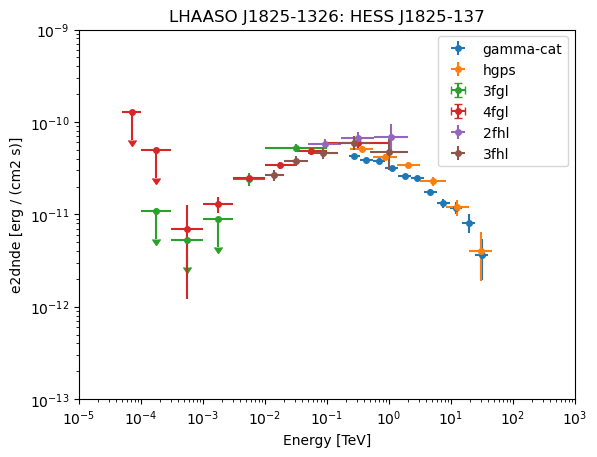

In [24]:
energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-13, 1e-9]
print_SED(sed_type = "e2dnde", yaxis_units="erg cm-2 s-1", energy_bounds=energy_bounds, ylim=ylim)

In [35]:
spec_model = LogParabolaSpectralModel(
    alpha=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", beta=0.1
)
sky_model = SkyModel(spectral_model=spec_model, name="logparabola")

datasets = Datasets(ds_src)
datasets.models = sky_model

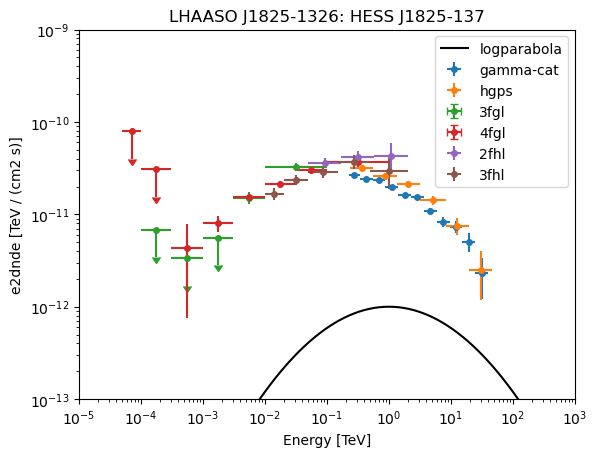

In [36]:
energy_bounds = [1e-5, 1e3] * u.TeV
ylim = [1e-13, 1e-9]
print_SED(spec_model=spec_model, sed_type = "e2dnde", yaxis_units="TeV cm-2 s-1", energy_bounds=energy_bounds, ylim=ylim)

In [ ]:
# LHAASO_id, TeVCount_id, ds_src

In [ ]:
df["Catalog"][src_index]

In [ ]:
cat_index = 0
cat_tag = df["Catalog"][src_index][cat_index]

In [ ]:
catalog = CATALOG_REGISTRY.get_cls(cat_tag)()
print(catalog)

In [ ]:
source  = catalog[TeVCount_src]
print(source.spectral_model())

In [ ]:
# source.sky_model()

In [ ]:
source.data

In [ ]:
# myData = read_csv(f"{path_name}/flux_points.csv", index_col = None)
# list(dict.fromkeys(myData["LHAASO"]))

In [ ]:
spec_model, sky_model = pwl_model()

datasets = Datasets(ds_src)

datasets.models = sky_model

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)


In [ ]:
sky_model.name

### Individual Source Analysis

In [ ]:
src_index = 0

LHAASO_src = list(dict(df["LHAASO"]).values())[src_index]
LHAASO_id = LHAASO_src.replace(" ", "")

TeVCount_src = list(dict(df["TeV Conterpart"]).values())[src_index]
TeVCount_id = TeVCount_src.replace(" ", "")

ds_src = ds_lst[src_index]

In [ ]:
cat_index = 1
cat_tag = df["Catalog"][src_index][cat_index]
source  = catalog[TeVCount_src]

In [ ]:
cat_tag

In [ ]:
source.data

In [ ]:
source.data.spec_type

In [ ]:
spec_model = source.spectral_model()

In [ ]:
sky_model = SkyModel(spectral_model=spec_model, name=source.data.spec_type)

In [ ]:
datasets = Datasets([ds_src[cat_index]])
datasets.models = sky_model

In [ ]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}
kwargs_fit = {"label":sky_model.name}
for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-2, 1e3] * u.TeV
spec_model.plot(energy_bounds=energy_bounds, color="k", **kwargs, **kwargs_fit)
spec_model.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-16, 1e-7)
ax.set_xlim(energy_bounds)

plt.title(f"{LHAASO_src}: {TeVCount_src}")
file = path_name / f'{LHAASO_id}_{TeVCount_id}_{sky_model.name}_{cat_tag}.png'
ax.legend()
plt.savefig(file, bbox_inches='tight')
plt.show()

In [ ]:
import operator

from gammapy.modeling.models import (
    Models,
    SkyModel,
    CompoundSpectralModel,
    SuperExpCutoffPowerLaw4FGLDR3SpectralModel,
)



secpl=model = SuperExpCutoffPowerLaw4FGLDR3SpectralModel(
    index_1=2.4649e+00,
    index_2=6.8682e-01,
    amplitude="1.2156e-11 MeV-1 cm-2 s-1",
    reference="2.2472e+03 MeV",
    expfactor=6.6507e-01,
)


pwl = PowerLawSpectralModel(
    index=2.0365e+00,
    amplitude="2.7277e-13 cm-2 s-1 TeV-1", 
    reference="2.0559e+00 TeV"
)

spec_model= CompoundSpectralModel(pwl, secpl, operator.add)


model = SkyModel(spectral_model=spec_model, name="j1507-pl")


datasets = Datasets([ds_src[2], ds_src[1]])
datasets.models = model

ax = plt.subplot()
ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-10, 1e7] * u.TeV
spec_model.plot(energy_bounds=energy_bounds, color="k", **kwargs)
spec_model.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-26, 1e-8)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

In [ ]:
df["Catalog"][src_index]

In [ ]:
cat_index = 1
cat_tag = df["Catalog"][src_index][cat_index]

In [ ]:
catalog = CATALOG_REGISTRY.get_cls(cat_tag)()

In [ ]:
source  = catalog[TeVCount_src]
# print(f"{catalog}\n{source}")

In [ ]:
source.data["SpectrumType"]

In [ ]:

def secpwl_model(index_1=2, index_2=1, amplitude="1e-12 TeV-1 cm-2 s-1",reference="1 TeV", expfactor=1e-2, name = "secpwl"):
    
    '''Returns a Super Exponential Cutoff Power Law Model used for 4FGL-DR3
    
    Default function parameters
    ----------
    index=2
    amplitude="1e-12 cm-2 s-1 TeV-1" 
    reference="1 TeV"
    name = None
    ----------
    
    pwl_model(index, amplitude, reference)
    >>> model 
     '''
    spec_model = SuperExpCutoffPowerLaw4FGLDR3SpectralModel(
        index_1=index_1,
        index_2=index_2,
        amplitude=amplitude,
        reference=reference,
        expfactor=expfactor,
    )
    
    sky_model = SkyModel(
    spectral_model=spec_model, 
    name= name
    )
    return spec_model, sky_model

In [ ]:
spec_model, sky_model = secpwl_model()


In [ ]:
spec_model, sky_model = secpwl_model()
# print(sky_model, asterisks())

datasets = Datasets(ds_src)

datasets.models = sky_model

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)
# print(datasets, asterisks())
# print(result_pwl, asterisks())
# print(sky_model, asterisks())
# ## nomear os datasets!

In [ ]:
# model.spectral_model.amplitude

In [ ]:
ds_lst[0][1].data.to_table(sed_type="dnde", formatted=True)

In [ ]:
# ds_lst[2]

In [ ]:
log_parabola = LogParabolaSpectralModel(
    alpha=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", beta=0.1
)
model = SkyModel(spectral_model=log_parabola, name="j1507-lp")

datasets.models = model
result_log_parabola = fitter.run(datasets=datasets)
# print(model)
# print(result_log_parabola)
ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde"}

ax.yaxis.set_units(u.Unit("erg cm-2 s-1"))
ax.xaxis.set_units(u.Unit("TeV"))

for d in datasets:
    d.data.plot(label=d.name, **kwargs)
energy_bounds = [1e-7, 1e2] * u.TeV

log_parabola.plot(energy_bounds=energy_bounds, color="k", **kwargs, label="LogParabola")
log_parabola.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-20, 1e-9)
ax.set_xlim(energy_bounds)
ax.legend(loc=1)
plt.title(f"{LHAASO_id}: {TeVCount_id}")
file = path_name / f'{LHAASO_id}_{TeVCount_id}_fit.png'
plt.savefig(file, bbox_inches='tight')
plt.show()

In [ ]:
print(result_log_parabola)

In [ ]:
models = Models([model])

type(models.to_yaml())

In [ ]:
print(models.to_parameters_table())

In [ ]:
from tabulate import tabulate

In [ ]:
Texttable = models.to_parameters_table()["name","value", "error", "unit"]

In [ ]:
headers=Texttable.colnames

In [ ]:
print(tabulate(Texttable,headers=headers,tablefmt="latex", floatfmt=".3e"))

In [ ]:
# help(tabulate)

In [ ]:
# table=Texttable
# df = pd.DataFrame(table.to_pandas)
# print(df)

In [ ]:
print(df.to_latex(index=False))

In [ ]:
models.write("models.yaml", overwrite=True)

In [ ]:
models_read = Models.read("models.yaml")

In [ ]:
type(models_read)

In [ ]:
models.write("models.yaml", overwrite=True)

models_read = Models.read("models.yaml")

In [ ]:
print(models_read)

In [ ]:
import yaml
from pprint import pprint
# convert yaml document to dict
data = yaml.load(models.to_yaml(), Loader=yaml.Loader)
print(data)


In [ ]:
df = pd.DataFrame(data) 
display(df) 

In [ ]:
# dfi.export(ff, 'TeVCounterpart/flux_points/flux_pointss.png')

In [ ]:
help(FluxPointsDataset)

In [ ]:
catalog_tag = ["gamma-cat", "hgps", "2hwc", "3fgl", "4fgl", "2fhl", "3fhl", "3hwc"] 
lst=[]
ds_lst = []
for i in range(len(TeVCount_dict.keys())):
    LHAASO = list(TeVCount_dict.keys())[i]

    for j in range(len(TeVCount_dict[LHAASO])):
        cat_off = []
        cat_on = []
        
        pf_off = []
        pf_on = []
        ds_j=[]
        TeVCount=TeVCount_dict[LHAASO][j]

        for k in range(len(catalog_tag)): 
            cat_name = catalog_tag[k]
            
            try:
                cat=CATALOG_REGISTRY.get_cls(cat_name)()
                src=cat[TeVCount]
                cat_on.append(catalog_tag[k])
                
                ds = FluxPointsDataset(
                    data=src.flux_points, 
                    name=cat_name
                )
                ds_j.append(ds)
                pf_on.append(catalog_tag[k])
            except:
                cat_off.append(catalog_tag[k])

            lst_k=[LHAASO, TeVCount, cat_on, pf_on]
        lst.append(lst_k)
        ds_lst.append(ds_j)
import pandas as pd 
# List1 
# lst = [['apple', 'red', 11], ['grape', 'green', 22], ['orange', 'orange', 33], ['mango', 'yellow', 44]] 
df = pd.DataFrame(lst, columns =['LHAASO', 'Conterpart', 'Catalog', 'Flux Points']) 
display(df) 

In [ ]:
type(src.flux_points)

In [ ]:
(ds_lst[1])

In [ ]:
print(ds_lst[1][0].data.iter_by_axis)

In [ ]:
ds_lst[0][0].data.sqrt_ts_threshold_ul

In [ ]:
print(ds_lst[1][0].data.energy_max)

In [ ]:
datasets = Datasets(ds_lst[1])
datasets.models = model
print(datasets)

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)

In [ ]:
ecpl = ExpCutoffPowerLawSpectralModel(
    index=1.8,
    amplitude="2e-12 cm-2 s-1 TeV-1",
    reference="1 TeV",
    lambda_="0.1 TeV-1",
)
model = SkyModel(spectral_model=ecpl, name="j1507-ecpl")

datasets.models = model
result_log_parabola = fitter.run(datasets=datasets)
# print(model)
# print(result_log_parabola)
ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde"}

ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

for d in datasets:
    d.data.plot(label=d.name, **kwargs)
energy_bounds = [1e-5, 1e3] * u.TeV

ecpl.plot(energy_bounds=energy_bounds, color="k", **kwargs, label="LogParabola")
ecpl.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-13, 1e-9)
ax.set_xlim(energy_bounds)
ax.legend(loc=1)
plt.title("LHAASOJ1825-1326: HESSJ1825-137")

plt.savefig("LHAASOJ1825-1326_HESSJ1825-137_fit", bbox_inches='tight')
plt.show()
